<a href="https://colab.research.google.com/github/Ppayel/BreastLocalSearchSSD/blob/main/Breast_Cancer_Mammograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To get the dataset from Kaggle

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 3.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=7de97b1661e1d9bf58dcda0c938a7bf04a96a378ba7925018c65769f557cafb2
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d 'skooch/ddsm-mammography'
!unzip -q '/content/ddsm-mammography.zip'

 99% 2.86G/2.88G [00:14<00:00, 190MB/s]
100% 2.88G/2.88G [00:14<00:00, 216MB/s]


In [ ]:
import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

*data pre-processing*

In [ ]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }
Image_height = 224
Image_width = 224

In [ ]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example
 
def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))
    
    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }   
 
    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])        
        image=image.numpy()
        image=cv2.resize(image,(Image_height,Image_width))
        image=cv2.merge([image,image,image])        
        #plt.imshow(image)
        images.append(image)
        labels.append(image_features['label_normal'].numpy())

In [ ]:
filenames=['/content/training10_3/training10_3.tfrecords',
#           '/content/training10_0/training10_0.tfrecords',
#          '/content/training10_2/training10_2.tfrecords',
#          '/content/training10_3/training10_3.tfrecords',
#          '/content/training10_4/training10_4.tfrecords'
          ]
 
for file in filenames:
    read_data(file)
 
print(len(images))
print(len(labels))

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Size of Training Dataset:  11177
<ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
11177
11177


In [ ]:
images = np.array(images)
labels = np.array(labels)
 

(224, 224, 3)


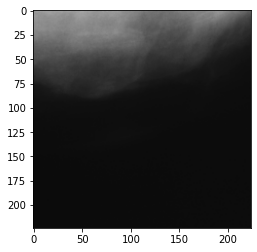

In [ ]:
plt.imshow(images[19])
print(images[0].shape)

* Split dataset into training, validation and testing sets*

In [ ]:
from sklearn.model_selection import train_test_split
train_images, valid_images, train_labels, valid_labels = train_test_split(images, labels, test_size=0.20, stratify = labels, random_state=10)
#print(len(images))
print(len(train_images))
print(len(valid_images))

8941
2236


In [ ]:
val_img, test_img, val_lab, test_lab = train_test_split(valid_images, valid_labels, test_size=0.5, stratify = valid_labels, random_state=50)
print(len(val_img))
print(len(test_img))

1118
1118


*Attention-aided VGG16*

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(train_images.shape[1:])
base_pretrained_model = VGG16(input_shape = train_images.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_features = base_pretrained_model(in_lay)
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)
# here we do an attention mechanism to turn pixels in the GAP on an off
attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = LocallyConnected2D(1, 
                                kernel_size = (1,1), 
                                padding = 'valid', 
                                activation = 'sigmoid')(attn_layer)
                        
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)

# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'elu')(gap_dr))
out_layer = Dense(1, activation = 'sigmoid')(dr_steps)

final_model = Model(inputs = [in_lay], outputs = [out_layer])
final_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 7, 7, 512)   2048        ['vgg16[1][0]']                  
 alization)                                                                                       
                             

*Training of the model*

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=6,restore_best_weights=True, verbose=1)

In [ ]:
final_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = final_model.fit(train_images, train_labels,validation_data=(val_img, val_lab),shuffle=True, epochs=40, batch_size=64,callbacks=[es])
loss_value , accuracy = final_model.evaluate(test_img, test_lab)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

#print(model.predict(x_test))
#model.save('breast_cance_model.h5')


Epoch 1/40
140/140 [==============================] - 83s 466ms/step - loss: 0.3412 - accuracy: 0.8587 - val_loss: 0.2902 - val_accuracy: 0.8909
Epoch 2/40
140/140 [==============================] - 47s 336ms/step - loss: 0.2720 - accuracy: 0.8863 - val_loss: 0.2499 - val_accuracy: 0.8927
Epoch 3/40
140/140 [==============================] - 49s 347ms/step - loss: 0.2573 - accuracy: 0.8968 - val_loss: 0.2401 - val_accuracy: 0.9052
Epoch 4/40
140/140 [==============================] - 49s 353ms/step - loss: 0.2420 - accuracy: 0.9053 - val_loss: 0.2437 - val_accuracy: 0.8989
Epoch 5/40
140/140 [==============================] - 51s 362ms/step - loss: 0.2311 - accuracy: 0.9072 - val_loss: 0.2301 - val_accuracy: 0.9159
Epoch 6/40
140/140 [==============================] - 51s 363ms/step - loss: 0.2120 - accuracy: 0.9169 - val_loss: 0.2323 - val_accuracy: 0.9070
Epoch 7/40
140/140 [==============================] - 51s 364ms/step - loss: 0.1870 - accuracy: 0.9272 - val_loss: 0.2243 - val_ac

In [ ]:
#plotting training values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
#epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(plt.xticks(1,21,1), accuracy, color='b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, color='r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='g', label='Training Loss')
plt.plot(epochs, val_loss, color='y', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

*Extraction of Deep Features and Classification with KNN Classifier*

In [ ]:
predictions = final_model.layers[-2].output
 
model_feat = keras.Model(inputs = final_model.inputs ,outputs = predictions)
 
Extracted_features = model_feat.predict(images)
print(Extracted_features.shape)

(11177, 128)


In [ ]:
train_image, valid_image, train_label, valid_label = train_test_split(Extracted_features, labels, test_size=0.20, stratify = labels, random_state=10)
val_img, test_img, val_lab, test_lab = train_test_split(valid_image, valid_label, test_size=0.5, stratify = valid_labels, random_state=50)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
_classifier = KNeighborsClassifier(n_neighbors=5)


In [ ]:
_classifier.fit(train_image, train_label)

KNeighborsClassifier()

In [ ]:
predictions = _classifier.predict(test_img)
acc = accuracy_score(y_true = test_lab, y_pred = predictions)
print(acc)

0.9069767441860465


*Applying FS with different FS algorithm on the extracted deep features*

In [ ]:
final_features = Extracted_features
lab = labels.reshape(labels.shape[0], 1)
print(final_features.shape)
print(lab.shape)
np.savetxt("ext_features.csv", final_features, delimiter=",")
np.savetxt("features_lab.csv", lab, delimiter=",")

(350, 128)
(350,)


In [ ]:
df = pd.read_csv('/content/ext_features.csv', header=None)
df2 = pd.read_csv('/content/features_lab.csv', header=None)
#x = df.iloc[:100, :128]
#print(x)
print(df.shape)
print(df2.shape)
total_features=df.shape[1]
x=df[df.columns[:total_features]]
y=df2[df2.columns[-1]]
print(y.shape)

(350, 128)
(350, 1)
(350,)


In [ ]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_Y, val_Y = train_test_split(x, y, test_size=0.20, stratify = labels, random_state=10)
val_X, test_X, val_Y, test_Y = train_test_split(valid_image, valid_label, test_size=0.5, stratify = valid_labels, random_state=50)

Algorithm: Local Search based SSD 

In [ ]:
import numpy as np
import pandas as pd
import math
import random
import time
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
 
 
''' 
rows = [1001]
cols = [1024]
for r in range(len(rows)):
  for c in range(len(cols)):
 
    #final_features = Extracted_features[:rows[r], :cols[c]]
    #lab = lab[:rows[r],:]
 
    np.savetxt("ext_features.csv", final_features, delimiter=",")
    np.savetxt('labels.csv', lab, delimiter= ',')
    df = pd.read_csv('/content/ext_features.csv')
    df2 = pd.read_csv('/content/labels.csv')
   
#print(df.shape)
#print('\nx: \n')
#tot_features=len(df.columns)-1
#x=df.iloc[:100, :128]
#y=df2.iloc[:100]
 
#x=df[df.columns]
 
#print(x.shape)
#print('\n')
#print(y.shape)
    #print('\n #Images: {}  #features: {}\n'.format(rows[r]-1, cols[c]))
 
    total_features=len(df.columns)
    x=df[df.columns[:total_features]]
    y=df2[df2.columns[-1]]
 '''
    #splitting dataset and applying KNN
''' 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
_classifier = KNeighborsClassifier(n_neighbors=5)
#
y_train = np.array(y_train, dtype=int)
y_test = np.array(y_test, dtype = int)
#
_classifier.fit(x_train, y_train)
predictions = _classifier.predict(x_test)
total_acc = accuracy_score(y_true = y_test, y_pred = predictions)
total_error = 1 - total_acc
'''
swarm_size = 50   #population size
max_iterations = 100
omega = 0.2  #used in the fitness function
delta=0.2   #to set an upper limit for including a slightly worse particle in LAHC


def mutate(agent):
  percent=0.2
  numChange=int(total_features*percent)
  pos=np.random.randint(0,total_features-1,numChange) #choose random positions to be mutated
  agent[pos]=1-agent[pos] #mutation
  return agent

def LAHC(particle):
            _lambda = 15 #upper limit on number of iterations in LAHC
            target_fitness = find_fitness(particle) #original fitness
            for i in range(_lambda):
                    new_particle = mutate(particle) #first mutation
                    temp = find_fitness(new_particle)
                    if temp < target_fitness:
                        particle = new_particle.copy() #updation
                        target_fitness = temp
                    elif (temp<=(1+delta)*target_fitness):
                        temp_particle = new_particle.copy()
                        for j in range(_lambda):
                            temp_particle1 = mutate(temp_particle) #second mutation
                            temp_fitness = find_fitness(temp_particle1)
                            if temp_fitness < target_fitness:
                                target_fitness=temp_fitness
                                particle=temp_particle1.copy() #updation
                            break
            return particle   

def randomwalk(agent):
    percent = 30
    percent /= 100
    neighbor = agent.copy()
    size = np.shape(agent)[0]
    upper = int(percent*size)
    if upper <= 1:
        upper = size
    x = random.randint(1,upper)
    pos = random.sample(range(0,size - 1),x)
    for i in pos:
        neighbor[i] = 1 - neighbor[i]
    return neighbor
 
def adaptiveBeta(agent):
    bmin = 0.1 #parameter: (can be made 0.01)
    bmax = 1
    maxIter = 10 # parameter: (can be increased )
    
    agentFit = find_fitness(agent)
    for curr in range(maxIter):
        neighbor = agent.copy()
        size = np.shape(neighbor)[0]
        neighbor = randomwalk(neighbor)
 
        beta = bmin + (curr / maxIter)*(bmax - bmin)
        for i in range(size):
            random.seed( time.time() + i )
            if random.random() <= beta:
                neighbor[i] = agent[i]
        neighFit = find_fitness(neighbor)
        if neighFit <= agentFit:
            agent = neighbor.copy()
            
 
 
    return agent

def find_fitness(particle):
            features = []
            for x in range(len(particle)):
                    if particle[x]>=0.5: #convert it to zeros and ones
                        features.append(df.columns[x])
            if(len(features)==0):
                        return 10000
            new_x_train = train_X[features].copy()
            new_x_test = test_X[features].copy()

            _classifier = KNeighborsClassifier(n_neighbors=5)
            _classifier.fit(new_x_train, train_Y)
            predictions = _classifier.predict(new_x_test).round()
            acc = accuracy_score(y_true = test_Y, y_pred = predictions)
            fitness = acc
            err=1-acc
            num_features = len(features)
            fitness =  alpha*err + (1-alpha)*(num_features/total_features)

            return fitness

def transfer_func(velocity): #to convert into an array of zeros and ones
            t=[]
            for i in range(len(velocity)):
                    t.append(abs(velocity[i]/(math.sqrt(1+velocity[i]*velocity[i])))) #transfer function inside paranthesis
            return t

#initialize swarm position and swarm velocity of SSD
swarm_vel = np.random.uniform(low=0, high=1, size=(swarm_size,total_features))

swarm_pos = np.random.uniform(size=(swarm_size,total_features))
swarm_pos = np.where(swarm_pos>=0.5,1,0)

c = 100
alpha= 0.9

gbest_fitness=100000
pbest_fitness = np.zeros(swarm_size)
pbest_fitness.fill(np.inf)  #initialize with the worse possible values
pbest = np.empty((swarm_size,total_features))
gbest = np.empty(total_features)
pbest.fill(np.inf)
gbest.fill(np.inf)

for itr in range(max_iterations):

                for i in range(swarm_size):
                  
                    #swarm_pos[i] = LAHC(swarm_pos[i]) # To activte LAHC local search 
                    swarm_pos[i] = adaptiveBeta(swarm_pos[i])   # To activte ABHC local search 
                    fitness = find_fitness(swarm_pos[i])

                    if fitness < gbest_fitness:

                        gbest=swarm_pos[i].copy() #updating global best
                        gbest_fitness=fitness



                    if fitness < pbest_fitness[i]:
                        pbest[i] = swarm_pos[i].copy() #updating personal best
                        pbest_fitness[i]=fitness

                    r1 = random.random()
                    r2 = random.random()

          #updating the swarm velocity
                    if r1 < 0.5:
                        swarm_vel[i] = c*math.sin(r2)*(pbest[i]-swarm_pos[i]) +math.sin(r2)* (gbest-swarm_pos[i])
                    else:
                        swarm_vel[i] = c*math.cos(r2)*(pbest[i]-swarm_pos[i]) + math.cos(r2)*(gbest-swarm_pos[i])
                    
          #decaying value of c
                    alpha= 0.9
                    c=alpha*c;
          
          #applying transfer function and then updating the swarm position
                    t = transfer_func(swarm_vel[i])
                    for j in range(len(swarm_pos[i])):
                        if(t[j] < 0.5):
                            swarm_pos[i][j] = swarm_pos[i][j]
                        else:
                            swarm_pos[i][j] = 1 - swarm_pos[i][j]



selected_features = gbest
print(gbest_fitness)
            
number_of_selected_features = np.sum(selected_features)
print("#",number_of_selected_features)

features=[]
for j in range(len(selected_features)):
                if selected_features[j]==1:
                        features.append(df.columns[j])
new_x_train = train_X[features]
new_x_test = test_X[features]

_classifier = KNeighborsClassifier(n_neighbors=5)
_classifier.fit(new_x_train, train_Y)
predictions = _classifier.predict(new_x_test).round()
acc = accuracy_score(y_true = test_Y, y_pred = predictions)
pre = precision_score(y_true = test_Y, y_pred = predictions)
rec = recall_score(y_true = test_Y, y_pred = predictions)
fitness = acc
print("Acc:",fitness)
print("Precision:", pre)
print("Recall:",rec)
print("\n\n")

0.10647321428571425
# 54
Acc: 0.9285714285714286
Precision: 1.0
Recall: 0.375





**To plot the ROC curve**

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, predictions)

auc = auc(fpr, tpr)
sc = roc_auc_score(y_test, predictions)
print(auc)
print(sc)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1],"--")

plt.plot(fpr, tpr, label='ROC curve (area = {:.3f})'.format(auc), color='orange')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

**Algorithm: Local Search based GSA, WOA, GWO, GA, PSO, SCA, HS, & EO.**

In [ ]:
from utils.LS_GA import GA
from utils.LS_GSA import GSA
from utils.LS_GWO import GWO
from utils.LS_WOA import WOA
from utils.LS_PSO import PSO
from utils.LS_SCA import SCA
from utils.LS_EO import EO
from utils.LS_HS import HS

In [ ]:
#solution, result = GA(20, 100, x, y, save_conv_graph=True)   # To run Local search based GA algorithm
#solution, result = GSA(20, 100, x, y, save_conv_graph=True)  # To run Local search based GSA algorithm
#solution, result = GWO(20, 100, x, y, save_conv_graph=True)  # To run Local search based GWO algorithm
solution, result = WOA(20, 100, x, y, save_conv_graph=True)   # To run Local search based WOA algorithm
#solution, result = PSO(20, 100, x, y, save_conv_graph=True)  # To run Local search based PSO algorithm
#solution, result = SCA(20, 100, x, y, save_conv_graph=True)  # To run Local search based SCA algorithm
#solution, result = EO(20, 100, x, y, save_conv_graph=True)   # To run Local search based EO algorithm
#solution, result = HS(20, 100, x, y, save_conv_graph=True)   # To run Local search based HS algorithm
print(result.accuracy)
print(result.precision)
print(result.recall)